# Integrating back orbits

The final test for a HVS is proving Galactic Center object, for this purpose we will use the full 6D astrometric solution and integrate back the orbit. If the point in which the object crosses the plane is the galactic center, and we can tell that with enough certainty, then the star will be confirmed as a Hills mechanims origin HVS.

imports and plotting

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table

from astropy.coordinates import SkyCoord, Galactocentric
import sys
# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.kde_classifier import *

# galpy

import astropy.units as u
from galpy.orbit import Orbit
from galpy.potential import McMillan17
from galpy.potential import MWPotential2014
from galpy.util.conversion import get_physical
import matplotlib.pyplot as plt
import os

from scipy.stats import gaussian_kde

In [2]:

# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


# Loading data

For testing we will load Brown et al. 2015 candidate list with Gaia EDR3 astrometry. This will provide Gaia proper motions, parallax and sky positions, which we can combine with Brown's radial velocity and spectroscopic distances to get the full parameter solution for each object

In [ ]:
brown_stars = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/targetsxGaiaEDR3.fits')
brown_stars['ra'] = brown_stars['ra_x']
brown_stars['dec'] = brown_stars['dec_x']

def flux_to_mag(flux):
    return -2.5*np.log10(flux)
brown_stars = extinction_correction(brown_stars)
brown_stars = implied_calculations(brown_stars)


brown_stars['bp_rp_corr_error'] = np.sqrt( flux_to_mag(brown_stars['phot_bp_mean_flux_error'])**2)

brown_stars['implied_M_g_corr'] = compute_absolute_magntiude(brown_stars['G_corr'], 1000/brown_stars['implied_parallax'],[0])
brown_stars['implied_M_g_corr_error'] = compute_absolute_magntiude(brown_stars['G_corr'], 1000/(brown_stars['implied_parallax']
                                                                    + brown_stars['implied_parallax_error']), [0])
brown_stars = brown_stars.to_pandas()
brown_stars['ID'] = brown_stars['ID'].apply(lambda x: x.decode('utf-8').replace(' ', ''))


Unit conversion error in plx and eplx
/Users/mncavieres/Documents/2024-2/HVS/scripts/selections.py:237: RuntimeWarning: invalid value encountered in log10
  return gmag - 5 * np.log10(distance) + 5 - extinction



## add the proper motions from Table 1 Brown et al. 2015

In [34]:
mu_ra = [0.08, -7.33, 0.52, -0.23, 0.55, 0.05, 1, -0.82, -1.26, -1.07, -0.40, -0.9, -1.61, -1.66, -0.96, -1.77]
mu_ra_error = [0.26, 0.58, 0.58, 0.36, 0.61, 0.57, 0.82, 1.16, 0.74, 0.36, 0.36, 0.38, 0.28, 0.52, 0.80, 0.79]

mu_dec = [-0.12, 2.28, 1.65, -0.42, -0.44, 0.31, -0.55, -0.04, -0.25, -0.58, 0.31, 0.46, -0.26, -1.15, 1.55, -3.71 ]
mu_dec_error = [0.22, 0.55, 0.57, 0.36, 0.59, 0.97, 1.04, 0.49, 0.7, 0.42, 0.34, 0.44, 0.42,  0.38, 0.86, 0.89]


# for the ones in gaia drop the 6th one
mu_ra = np.delete(mu_ra, 5)
mu_ra_error = np.delete(mu_ra_error, 5)
mu_dec = np.delete(mu_dec, 5)
mu_dec_error = np.delete(mu_dec_error, 5)

brown_stars['mu_ra'] = mu_ra
brown_stars['mu_ra_error'] = mu_ra_error
brown_stars['mu_dec'] = mu_dec
brown_stars['mu_dec_error'] = mu_dec_error


# Define orbit integration and determine the plane crossing point. 


The following function will integrate the orbit for integration_time in n_steps. Then return the X, Y point at which the orbit has the lowest $Z^2$ value, therefore assuming that the star went through the plane at a certain point during the orbit. 

In [121]:
from galpy.potential.mwpotentials import McMillan17

def integrate_orbits_to_plane_crossing_mcmillan(star, ra_col = 'RAx', dec_col = 'DECx', pmra_col = 'pmra',
                                        pmdec_col = 'pmdec', d_col = 'd_helio', v_col = 'v_helio',
                                        pmra_error_col = 'pmra_error', pmdec_error_col = 'pmdec_error',
                                        d_col_error = 'd_helio_error', v_col_error = 'v_helio_error',
                                       output_path=None, n_samples=100, integration_time=-10*u.Gyr, 
                                       n_steps=3000):
    """
    Integrate orbits of a star back in time and find the closest approach to X, Y, Z = 0.
    
    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio', 
                                         'pmra_error', 'pmdec_error', 'd_helio_error', 'v_helio_error'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: Quantity
      Integration time into the past (negative for backward integration).
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """

    # Define physical scales
    ro = 8.21  # Distance scale in kpc (e.g., Sun-Galactic Center distance)
    vo = 233.1  # Velocity scale in km/s

    # Create time grid
    time_grid = np.linspace(0, integration_time.value, n_steps) * integration_time.unit
    
    # Extract data and errors
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]
    pmra_err = star[pmra_error_col].iloc[0]
    pmdec_err = star[pmdec_error_col].iloc[0]
    d_helio_err = star[d_col_error].iloc[0]
    v_helio_err = star[v_col_error].iloc[0]
    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    closest_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbit for central values
    coord_central = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, 
                      distance=d_helio*u.kpc, pm_ra_cosdec=pmra*u.mas/u.yr, 
                      pm_dec=pmdec*u.mas/u.yr, radial_velocity=v_helio*u.km/u.s)
    galactic = coord_central.transform_to(Galactocentric())

    # Initialize orbit
    vx = galactic.v_x.to_value(u.km/u.s)
    vy = galactic.v_y.to_value(u.km/u.s)
    vz = galactic.v_z.to_value(u.km/u.s)
    o = Orbit(vxvv=[galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc), 
                    vx, vy, vz], **get_physical(McMillan17))
    
    # Integrate orbit
    o.integrate(time_grid, McMillan17)
    
    # Find the x, y position at the plane crossing
    x_central, y_central, z_central = o.x(time_grid), o.y(time_grid), o.z(time_grid)
    distances = np.sqrt(z_central**2)
    min_idx = np.argmin(distances)
    periapse = (x_central[min_idx], y_central[min_idx], z_central[min_idx])
    


    # Integrate orbits for each sample
    for i in tqdm(range(n_samples)):
        # Transform to Galactocentric frame
        c = SkyCoord(ra=ra_samples[i]*u.deg, dec=dec_samples[i]*u.deg, 
                      distance=d_samples[i]*u.kpc, pm_ra_cosdec=pmra_samples[i]*u.mas/u.yr, 
                      pm_dec=pmdec_samples[i]*u.mas/u.yr, radial_velocity=v_samples[i]*u.km/u.s)
      
        # Initialize orbit in RA, DEC, D, PMRA, PMDEC, VOrbit([RA,Dec,distance,pmRA,pmDec,Vlos],radec=True) 
        o = Orbit([c.ra, c.dec, c.distance,c.pm_ra_cosdec, c.pm_dec, c.radial_velocity ], radec= True, **get_physical(McMillan17))
        
        # Integrate orbit
        o.integrate(time_grid, McMillan17)
        
        # Find the x, y position at the plane crossing
        x, y, z = o.x(time_grid), o.y(time_grid), o.z(time_grid)
        distances = np.sqrt(z**2)
        min_idx = np.argmin(distances)
        periapse = (x[min_idx], y[min_idx], z[min_idx])
        closest_origins.append(periapse)
        
        # Save orbit data to file (optional)
        if output_path:
            orbit_data = np.array([x, y, z, o.vx(time_grid), o.vy(time_grid), o.vz(time_grid)]).T
            filename = os.path.join(output_path, f"star_sample_{i}.txt")
            np.savetxt(filename, orbit_data, 
                       header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return closest_origins, x_central, y_central, z_central, coord_central

In [117]:
def plot_closest_origins(origins, xlim=(-60, 60), ylim=(-60, 60)):
    """
    Plot the closest approach points in the X-Y plane.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    """
    # Extract X, Y positions
    x = np.array([origin[0].value for origin in origins])
    y = np.array([origin[1].value for origin in origins])
    
    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    #xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Plot the KDE as a contour plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=30, cmap="Blues")
    plt.colorbar(label="Density")
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark the Galactic Center

    # solar circle
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    # add circle with a 15 kpc radius
    circle2 = plt.Circle((0, 0), 15, color='g', fill=False, linestyle='--', label='15 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Closest Approach Points in X-Y Plane')
    plt.legend(loc = 'upper right')
    plt.grid(True)
    plt.show()


# Test on HVS3

In [118]:

hvs3 = brown_stars.loc[brown_stars['ID'] == 'HVS3']


In [119]:
# now for all stars

plane_crossing, x, y, z, coords = integrate_orbits_to_plane_crossing_mcmillan(hvs3, n_samples=100,
                                                            integration_time=-100*u.Myr, 
                                                            n_steps=1000, pmra_col='mu_ra',
                                                            pmdec_col='mu_dec',
                                                            pmra_error_col='mu_ra_error',
                                                            pmdec_error_col='mu_dec_error')

100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


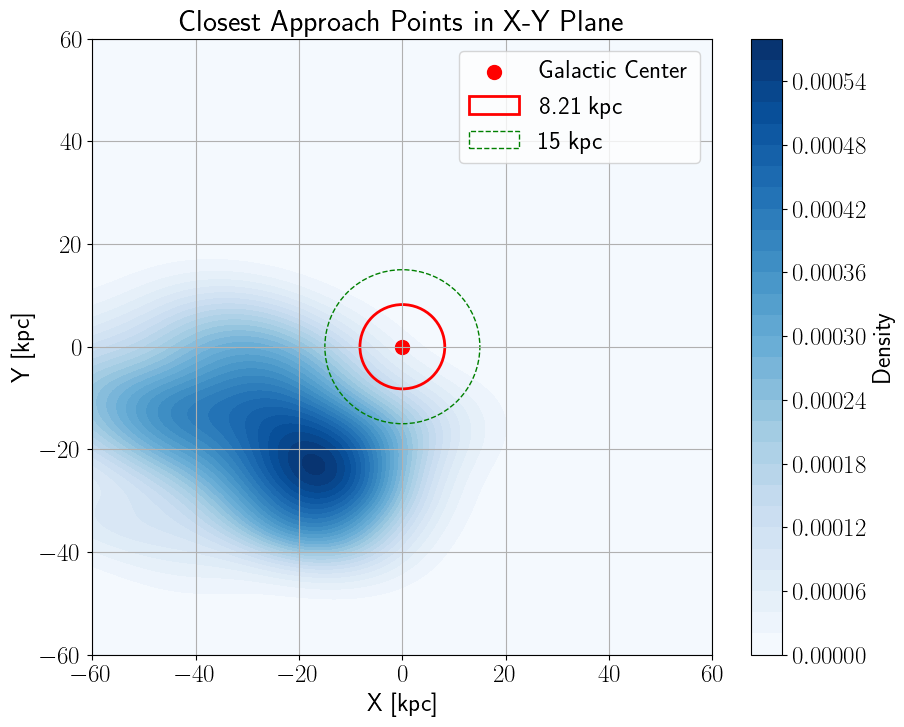

In [120]:
plot_closest_origins(plane_crossing, xlim=(-60, 60), ylim=(-60, 60))

In [133]:
# check if the points in the orbit match with the initial conditions
# transform to galactocentric coordinates
galactic = coords.transform_to(Galactocentric())

x_initial = galactic.x.to_value(u.kpc)
y_initial = galactic.y.to_value(u.kpc)
z_initial = galactic.z.to_value(u.kpc)


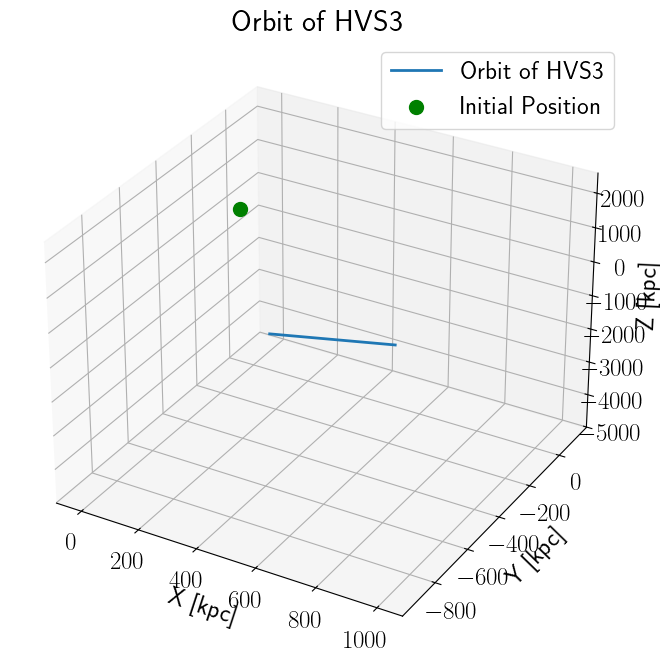

In [137]:
# 3d plot of the orbit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=2, label='Orbit of HVS3')
#ax.scatter(0, 0, 0, color='red', label='Galactic Center', s=100)
# plot the galactic plane at z=0
# Parameters for the circular galactic plane
radius = 20  # Radius of the circle (in kpc)
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = radius * np.cos(theta)
y_circle = radius * np.sin(theta)
z_circle = np.zeros_like(theta)  # Circle lies in the Z=0 plane

# Plot the galactic plane as a circle
#ax.plot(x_circle, y_circle, z_circle, color='blue', alpha=0.6, label='Galactic Plane')

ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
#ax.set_xlim(-60, 60)
#ax.set_ylim(-60, 60)
#ax.set_zlim(-60, 60)
# plot initial position
#ax.scatter(x[0], y[0], z[0], color='green', label='Initial Position', s=100)
ax.scatter(x_initial, y_initial, z_initial, color='green', label='Initial Position', s=100)
ax.legend()

ax.set_title('Orbit of HVS3')
plt.show()


In [132]:
# save orbit data to fits
orbit_hvs3 = Table()
orbit_hvs3['X'] = x
orbit_hvs3['Y'] = y
orbit_hvs3['Z'] = z

orbit_hvs3.write('/Users/mncavieres/Documents/2024-2/HVS/Data/Brown_targets/orbits/HVS3_orbit.fits', overwrite=True)